<h1>Imports</h1>

In [28]:
import tensorflow as tf
TF_FORCE_GPU_ALLOW_GROWTH= True
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)  
    except RuntimeError as e:
        print(e)
else:
    print("No GPU available. Using the CPU instead.")

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shap


import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import warnings
warnings.filterwarnings("ignore")

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import Rescaling, RandomZoom, RandomFlip , RandomRotation
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import Dense , Dropout, BatchNormalization , GlobalAveragePooling2D , Conv2D , MaxPooling2D , Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense , AveragePooling2D , Dropout
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.model_modifiers import ModelModifier
from tf_keras_vis.utils.scores import CategoricalScore
from tensorflow.keras.applications import MobileNetV2, VGG16, EfficientNetV2B0, EfficientNetV2B3
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight
from collections import Counter



<h1> Load Dataset </h1>

In [ ]:

trainining_data_path = 'brain_images/Training/' # Path to folder containing training image data
testing_data = 'brain_images/Testing/' # Path to folder containing testing image data

tf.random.set_seed(123)

BATCH_SIZE = 32 
IMAGE_SIZE = (160, 160)

image_paths_training = []
labels = []

for class_folder in os.listdir(trainining_data_path):
    class_folder_path = os.path.join(trainining_data_path, class_folder)
    if os.path.isdir(class_folder_path):
        for image_file in os.listdir(class_folder_path):
            if image_file.endswith('.jpg') or image_file.endswith('.png'):
                image_paths_training.append(os.path.join(class_folder_path, image_file))
                labels.append(class_folder)

image_paths_testing = []
testing_labels = []

for class_folder in os.listdir(testing_data):
    class_folder_path = os.path.join(testing_data, class_folder)
    if os.path.isdir(class_folder_path):
        for image_file in os.listdir(class_folder_path):
            if image_file.endswith('.jpg') or image_file.endswith('.png'):
                image_paths_testing.append(os.path.join(class_folder_path, image_file))
                testing_labels.append(class_folder)

print("Number of training images: ", len(image_paths_training))
print("Number of testing images: ", len(image_paths_testing))

label_counts_training = Counter(labels)
print("Label counts in training data: ", label_counts_training)

label_counts_testing = Counter(testing_labels)
print("Label counts in testing data: ", label_counts_testing)


Number of training images:  5712
Number of testing images:  1311
Label counts in training data:  Counter({'notumor': 1595, 'pituitary': 1457, 'meningioma': 1339, 'glioma': 1321})
Label counts in testing data:  Counter({'notumor': 405, 'meningioma': 306, 'pituitary': 300, 'glioma': 300})


<h1> Visualising Dataset</h1>

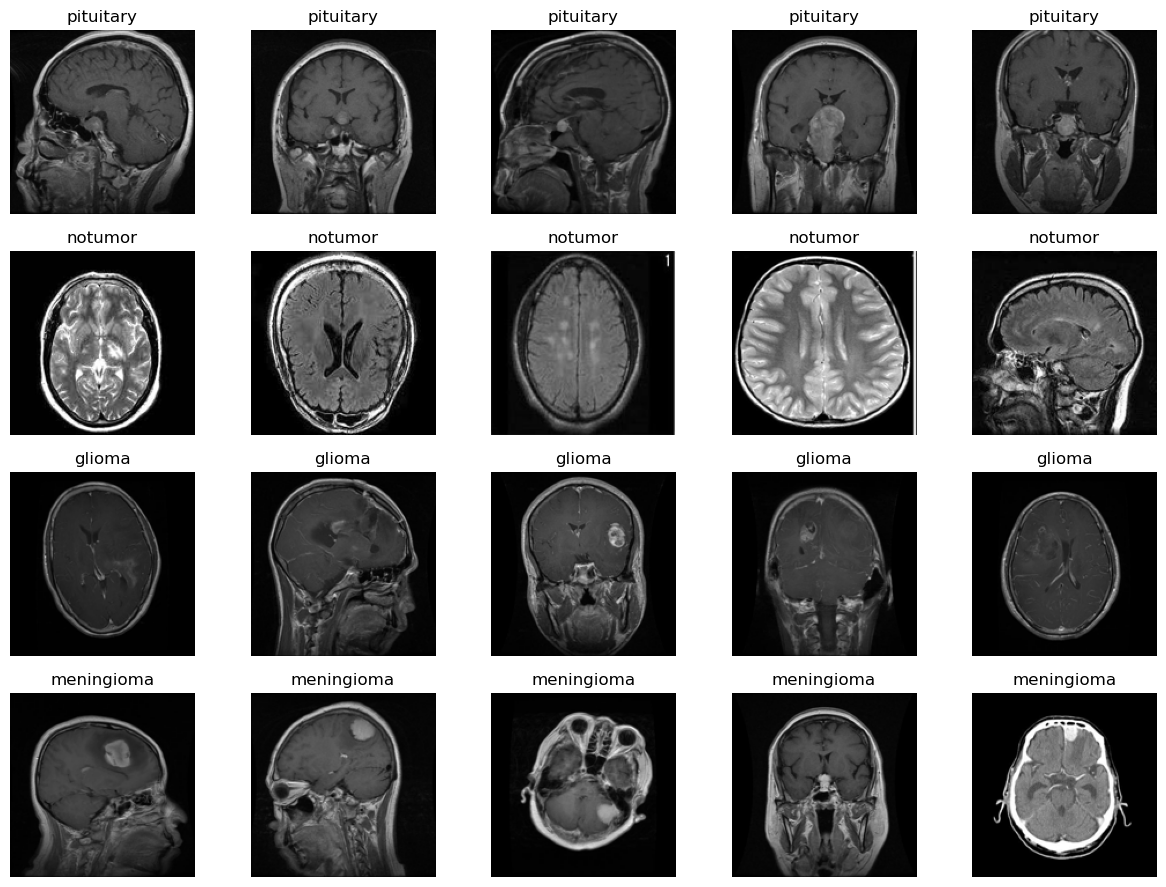

In [ ]:
from PIL import Image
from collections import defaultdict

def load_images(image_paths, target_size):
    return np.array([np.array(Image.open(path).convert('RGB').resize(target_size)) for path in image_paths])

def plotImages(images, labels):
    plt.figure(figsize=[15,11])                 
    
    images_by_class = defaultdict(list)
    for image, label in zip(images, labels):
        images_by_class[label].append(image)
    
    selected_images = [image for images in images_by_class.values() for image in images[:5]]
    selected_labels = [label for label, images in images_by_class.items() for image in images[:5]]
    
    for i in range(len(selected_images)):
        plt.subplot(len(images_by_class), 5, i+1)  
        plt.imshow(selected_images[i])             
        plt.title(selected_labels[i])              
        plt.axis("off")
    plt.show()

images = load_images(image_paths_training, IMAGE_SIZE)

plotImages(images, labels)

<h1> Model </h1>

In [29]:
from keras.regularizers import l2
from keras.layers import Input

def create_model():
    dropout_rate = 0.5 
    
    # EfficientNetV2B0_model = EfficientNetV2B0(input_shape=IMAGE_SIZE + (3,), weights='imagenet', include_top=False, pooling='max')
    MobileNetV2_model = MobileNetV2(input_shape=IMAGE_SIZE + (3,), weights='imagenet', include_top=False, pooling='max')

    # model = Sequential([
    #     EfficientNetV2B0_model,
    #     Dropout(dropout_rate),
    #     BatchNormalization(),
    #     Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    #     Dropout(dropout_rate),
    #     Dense(4, activation='softmax')
    # ])

    # input_tensor = Input(shape=IMAGE_SIZE + (3,))
    # x = EfficientNetV2B0_model(input_tensor)
    # x = Dropout(dropout_rate)(x)
    # x = BatchNormalization()(x)
    # x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
    # x = Dropout(dropout_rate)(x)
    # output_tensor = Dense(4, activation='softmax')(x)

    # model = Model(inputs=input_tensor, outputs=output_tensor)

    input_tensor = Input(shape=IMAGE_SIZE + (3,))
    EfficientNetV2B3_model = EfficientNetV2B3(input_shape=IMAGE_SIZE + (3,), weights='imagenet', include_top=False, pooling='max', input_tensor=input_tensor)

    max_pool = EfficientNetV2B3_model.get_layer('max_pool')
    x = Dropout(dropout_rate)(max_pool.output)
    x = BatchNormalization()(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(4, activation='softmax')(x)
    model = Model(inputs=input_tensor, outputs=x)
    model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate = 0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    
    return model

<h1>K-cross validation</h1>

In [30]:

skf = StratifiedKFold(n_splits=5 ,shuffle=True, random_state=123)

models_and_scores = []
class_names = []

test_generator = None

for train_index, val_index in skf.split(image_paths_training, labels):
    train_paths, val_paths = np.array(image_paths_training)[train_index], np.array(image_paths_training)[val_index]
    train_labels, val_labels = np.array(labels)[train_index], np.array(labels)[val_index]
    
    train_df = pd.DataFrame({'path': train_paths, 'label': train_labels})
    val_df = pd.DataFrame({'path': val_paths, 'label': val_labels})
    test_df = pd.DataFrame({'path': image_paths_testing, 'label': testing_labels})

    #How many images are in each class
    print("Train class distribution: ", train_df['label'].value_counts())


    train_datagen = IDG(
                shear_range= 0.3,  
                zoom_range = 0.4,  
                width_shift_range = 0.3,  
                height_shift_range = 0.3,
                horizontal_flip=True,
                rotation_range=20,
                fill_mode = "nearest")
    

    val_datagen = IDG()
    

    test_datagen = IDG()

    train_generator = train_datagen.flow_from_dataframe(train_df, x_col='path', y_col='label', target_size=IMAGE_SIZE, class_mode='categorical', shuffle=True, color_mode='rgb', batch_size = BATCH_SIZE)
    val_generator = val_datagen.flow_from_dataframe(val_df, x_col='path', y_col='label', target_size=IMAGE_SIZE, class_mode='categorical', shuffle=True, color_mode='rgb', batch_size = BATCH_SIZE)
    test_generator = test_datagen.flow_from_dataframe(test_df, x_col='path', y_col='label', target_size=IMAGE_SIZE, class_mode='categorical', shuffle=True, color_mode='rgb', batch_size = BATCH_SIZE)

    class_names = list(test_generator.class_indices)
    
    model = create_model()  

    class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
    class_weights = dict(enumerate(class_weights))

    model.fit(train_generator, epochs=10, validation_data=val_generator, class_weight=class_weights, verbose = 1)

    score = model.evaluate(test_generator)
    print(score)

    models_and_scores.append((model, score))

best_model, best_score = max(models_and_scores, key=lambda x: x[1][1])

Train class distribution:  label
notumor       1276
pituitary     1165
meningioma    1071
glioma        1057
Name: count, dtype: int64
Found 4569 validated image filenames belonging to 4 classes.
Found 1143 validated image filenames belonging to 4 classes.


Found 1311 validated image filenames belonging to 4 classes.
52606240/52606240 [==============================] - 2s 0us/step
Epoch 1/10


2024-03-25 16:38:11.731232: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_20/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


143/143 [==============================] - 45s 128ms/step - loss: 4.4078 - accuracy: 0.3235 - val_loss: 3.1665 - val_accuracy: 0.7069
Epoch 2/10
143/143 [==============================] - 19s 130ms/step - loss: 3.7934 - accuracy: 0.4850 - val_loss: 2.9608 - val_accuracy: 0.7533
Epoch 3/10
143/143 [==============================] - 19s 129ms/step - loss: 3.3880 - accuracy: 0.6093 - val_loss: 2.8477 - val_accuracy: 0.7892
Epoch 4/10
143/143 [==============================] - 19s 130ms/step - loss: 3.1417 - accuracy: 0.6940 - val_loss: 2.7889 - val_accuracy: 0.8233
Epoch 5/10
143/143 [==============================] - 19s 130ms/step - loss: 2.9764 - accuracy: 0.7529 - val_loss: 2.7810 - val_accuracy: 0.8198
Epoch 6/10
143/143 [==============================] - 19s 131ms/step - loss: 2.8767 - accuracy: 0.7761 - val_loss: 2.7514 - val_accuracy: 0.8276
Epoch 7/10
143/143 [==============================] - 18s 127ms/step - loss: 2.7642 - accuracy: 0.8041 - val_loss: 2.6516 - val_accuracy: 0.8

2024-03-25 16:41:46.486952: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_21/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


143/143 [==============================] - 41s 126ms/step - loss: 4.2685 - accuracy: 0.3276 - val_loss: 3.1466 - val_accuracy: 0.6999
Epoch 2/10
143/143 [==============================] - 19s 129ms/step - loss: 3.7175 - accuracy: 0.4942 - val_loss: 2.9786 - val_accuracy: 0.7472
Epoch 3/10
143/143 [==============================] - 19s 130ms/step - loss: 3.3728 - accuracy: 0.6089 - val_loss: 2.8857 - val_accuracy: 0.7892
Epoch 4/10
143/143 [==============================] - 19s 130ms/step - loss: 3.1232 - accuracy: 0.6971 - val_loss: 2.8468 - val_accuracy: 0.8145
Epoch 5/10
143/143 [==============================] - 19s 131ms/step - loss: 2.9993 - accuracy: 0.7424 - val_loss: 2.7679 - val_accuracy: 0.8460
Epoch 6/10
143/143 [==============================] - 19s 129ms/step - loss: 2.8336 - accuracy: 0.7849 - val_loss: 2.7073 - val_accuracy: 0.8600
Epoch 7/10
143/143 [==============================] - 18s 128ms/step - loss: 2.7270 - accuracy: 0.8083 - val_loss: 2.6485 - val_accuracy: 0.8

2024-03-25 16:45:19.452590: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_22/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


143/143 [==============================] - 41s 123ms/step - loss: 4.2949 - accuracy: 0.3567 - val_loss: 3.0858 - val_accuracy: 0.7198
Epoch 2/10
143/143 [==============================] - 18s 127ms/step - loss: 3.7394 - accuracy: 0.4961 - val_loss: 2.8906 - val_accuracy: 0.7793
Epoch 3/10
143/143 [==============================] - 18s 126ms/step - loss: 3.3641 - accuracy: 0.6168 - val_loss: 2.9507 - val_accuracy: 0.7828
Epoch 4/10
143/143 [==============================] - 18s 126ms/step - loss: 3.1389 - accuracy: 0.6952 - val_loss: 2.8851 - val_accuracy: 0.7986
Epoch 5/10
143/143 [==============================] - 18s 128ms/step - loss: 3.0012 - accuracy: 0.7440 - val_loss: 2.8262 - val_accuracy: 0.8336
Epoch 6/10
143/143 [==============================] - 18s 128ms/step - loss: 2.8669 - accuracy: 0.7836 - val_loss: 2.7434 - val_accuracy: 0.8441
Epoch 7/10
143/143 [==============================] - 19s 130ms/step - loss: 2.7752 - accuracy: 0.8044 - val_loss: 2.6615 - val_accuracy: 0.8

2024-03-25 16:48:49.682690: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_23/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


143/143 [==============================] - 41s 123ms/step - loss: 4.2459 - accuracy: 0.3558 - val_loss: 3.1835 - val_accuracy: 0.6883
Epoch 2/10
143/143 [==============================] - 18s 127ms/step - loss: 3.7865 - accuracy: 0.4902 - val_loss: 2.9286 - val_accuracy: 0.7627
Epoch 3/10
143/143 [==============================] - 18s 129ms/step - loss: 3.4394 - accuracy: 0.6048 - val_loss: 2.8271 - val_accuracy: 0.7977
Epoch 4/10
143/143 [==============================] - 18s 128ms/step - loss: 3.1901 - accuracy: 0.6875 - val_loss: 2.7715 - val_accuracy: 0.8161
Epoch 5/10
143/143 [==============================] - 19s 131ms/step - loss: 2.9887 - accuracy: 0.7481 - val_loss: 2.7306 - val_accuracy: 0.8284
Epoch 6/10
143/143 [==============================] - 18s 128ms/step - loss: 2.8553 - accuracy: 0.7761 - val_loss: 2.5977 - val_accuracy: 0.8687
Epoch 7/10
143/143 [==============================] - 19s 129ms/step - loss: 2.7762 - accuracy: 0.8044 - val_loss: 2.6048 - val_accuracy: 0.8

2024-03-25 16:52:19.756135: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_24/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


143/143 [==============================] - 40s 120ms/step - loss: 4.3100 - accuracy: 0.3519 - val_loss: 3.1853 - val_accuracy: 0.7067
Epoch 2/10
143/143 [==============================] - 19s 130ms/step - loss: 3.8127 - accuracy: 0.4895 - val_loss: 2.9316 - val_accuracy: 0.7697
Epoch 3/10
143/143 [==============================] - 19s 129ms/step - loss: 3.4226 - accuracy: 0.6046 - val_loss: 2.8217 - val_accuracy: 0.8065
Epoch 4/10
143/143 [==============================] - 18s 128ms/step - loss: 3.1497 - accuracy: 0.6939 - val_loss: 2.7328 - val_accuracy: 0.8301
Epoch 5/10
143/143 [==============================] - 19s 129ms/step - loss: 2.9684 - accuracy: 0.7468 - val_loss: 2.6148 - val_accuracy: 0.8616
Epoch 6/10
143/143 [==============================] - 18s 128ms/step - loss: 2.8186 - accuracy: 0.7836 - val_loss: 2.6737 - val_accuracy: 0.8546
Epoch 7/10
143/143 [==============================] - 18s 127ms/step - loss: 2.7017 - accuracy: 0.8225 - val_loss: 2.5752 - val_accuracy: 0.8

<h1> Grad-Cam</h1>

In [31]:
from keras.preprocessing.image import load_img, img_to_array

images_list, labels_list = [], []
for _ in range(len(test_generator)):
    images_batch, labels_batch = next(test_generator)
    images_list.extend(images_batch)
    labels_list.extend(labels_batch)

# Randomly select 10 indices
indices = np.random.choice(len(images_list), size=10, replace=False)

# Get the corresponding images and labels
random_images = np.array([images_list[i] for i in indices])
random_labels = [labels_list[i] for i in indices]

# Make predictions
predictions = best_model.predict(random_images)


# Evaluate the model
evaluations = best_model.evaluate(random_images, np.array(random_labels))

# Get the predicted classes
predicted_classes = np.argmax(predictions, axis=1)

# Get the actual classes
actual_classes = [np.argmax(label) for label in random_labels]

print(f"Predicted loss: {evaluations}")
print(f"Random images: {random_images.shape}")


gradcam = GradcamPlusPlus(best_model, model_modifier=ReplaceToLinear())



plt.figure(figsize=(11, 11))

for i, (image, actual_class, predicted_class) in enumerate(zip(images, actual_classes, predicted_classes)):
    loss = CategoricalScore(predicted_class)

    print(f"Loss: {loss}")
    print(f"Image: {image.shape}")
    
    heatmap = gradcam(loss, np.array([image]))

    plt.subplot(5, 2, i + 1)
    
    plt.imshow(image, alpha=1.0)
    
    plt.imshow(heatmap[0], cmap='jet', alpha=0.6)
    
    plt.title(f"Actual: {class_names[actual_class]}, Predicted: {class_names[predicted_class]}")
    plt.axis("off")

plt.show()

1/1 [==============================] - 0s 28ms/step - loss: 2.1291 - accuracy: 1.0000
Predicted loss: [2.1290810108184814, 1.0]
Random images: (10, 160, 160, 3)
Loss: <tf_keras_vis.utils.scores.CategoricalScore object at 0x7f131eece790>
Image: (160, 160, 3)


AttributeError: 'NoneType' object has no attribute 'ndim'

<Figure size 1100x1100 with 0 Axes>